<a href="https://colab.research.google.com/github/Fu-Pei-Yin/Deep-Generative-Mode/blob/main/%E6%B7%B1%E5%BA%A6%E7%94%9F%E6%88%90%E6%A8%A1%E5%9E%8Bweek1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用設備: cuda
下載 MNIST 資料集...
檔案已存在: train-images-idx3-ubyte.gz
檔案已存在: train-labels-idx1-ubyte.gz
檔案已存在: t10k-images-idx3-ubyte.gz
檔案已存在: t10k-labels-idx1-ubyte.gz
訓練數據: 60000 個樣本
測試數據: 10000 個樣本
模型結構:
VAE(
  (encoder_fc1): Linear(in_features=784, out_features=400, bias=True)
  (encoder_fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  (decoder_fc1): Linear(in_features=20, out_features=400, bias=True)
  (decoder_fc2): Linear(in_features=400, out_features=400, bias=True)
  (decoder_fc3): Linear(in_features=400, out_features=784, bias=True)
)
可訓練參數數量: 973624
開始訓練 VAE 模型...


Epoch 1: 100%|██████████| 469/469 [00:02<00:00, 174.38it/s, Loss=137.26, BCE=124.20, KLD=13.06]



Epoch 1 結果:
訓練損失: 179.0055 (BCE: 171.8066, KLD: 7.1989)
測試損失: 139.1199
----------------------------------------


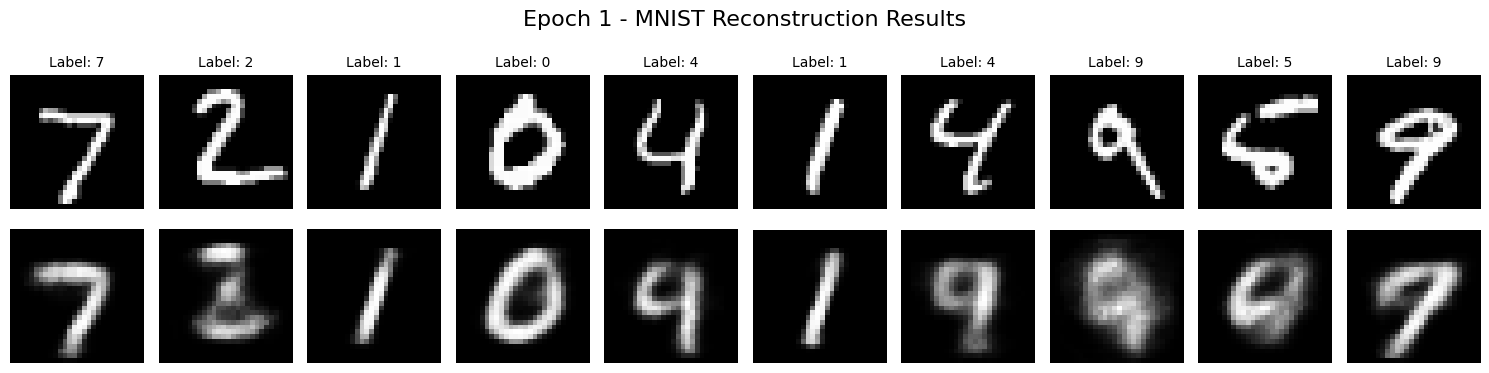

Epoch 2: 100%|██████████| 469/469 [00:02<00:00, 157.18it/s, Loss=121.16, BCE=104.80, KLD=16.36]



Epoch 2 結果:
訓練損失: 128.4061 (BCE: 113.3274, KLD: 15.0787)
測試損失: 119.4445
----------------------------------------


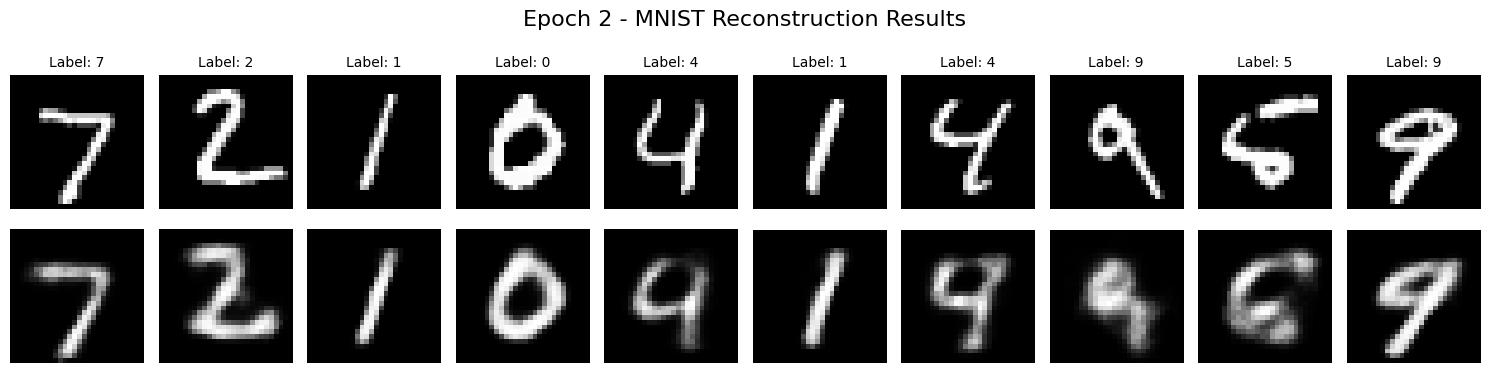

Epoch 3: 100%|██████████| 469/469 [00:02<00:00, 173.24it/s, Loss=113.10, BCE=96.42, KLD=16.68]



Epoch 3 結果:
訓練損失: 117.1552 (BCE: 100.4586, KLD: 16.6967)
測試損失: 113.3433
----------------------------------------


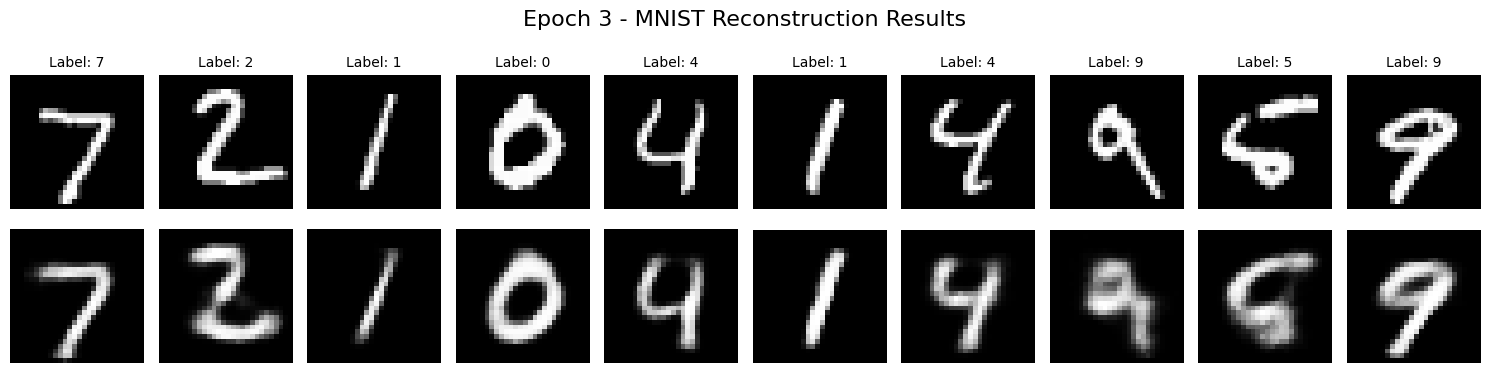

Epoch 4: 100%|██████████| 469/469 [00:02<00:00, 171.51it/s, Loss=105.95, BCE=88.33, KLD=17.63]



Epoch 4 結果:
訓練損失: 112.4867 (BCE: 94.7809, KLD: 17.7058)
測試損失: 110.2228
----------------------------------------


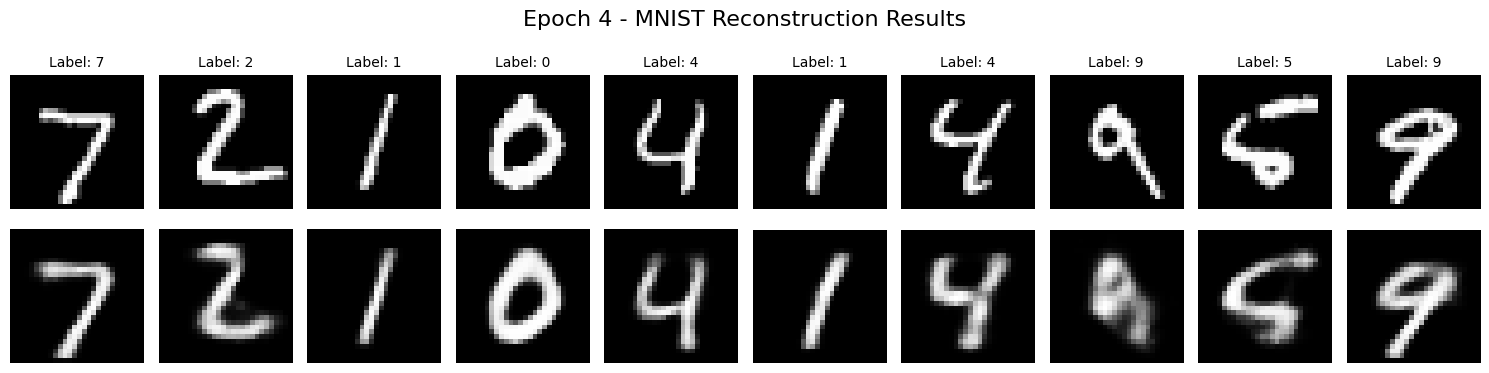

Epoch 5: 100%|██████████| 469/469 [00:03<00:00, 140.96it/s, Loss=106.91, BCE=88.08, KLD=18.83]



Epoch 5 結果:
訓練損失: 109.5329 (BCE: 91.0653, KLD: 18.4676)
測試損失: 107.7830
----------------------------------------


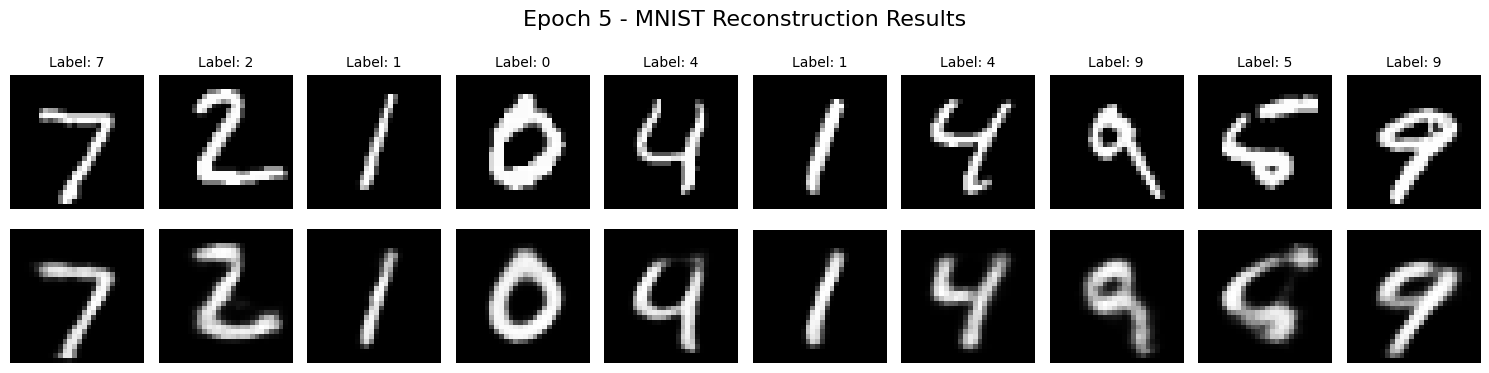


訓練完成!
Epoch 1: 訓練損失: 179.0055 (BCE: 171.8066, KLD: 7.1989), 測試損失: 139.1199
Epoch 2: 訓練損失: 128.4061 (BCE: 113.3274, KLD: 15.0787), 測試損失: 119.4445
Epoch 3: 訓練損失: 117.1552 (BCE: 100.4586, KLD: 16.6967), 測試損失: 113.3433
Epoch 4: 訓練損失: 112.4867 (BCE: 94.7809, KLD: 17.7058), 測試損失: 110.2228
Epoch 5: 訓練損失: 109.5329 (BCE: 91.0653, KLD: 18.4676), 測試損失: 107.7830


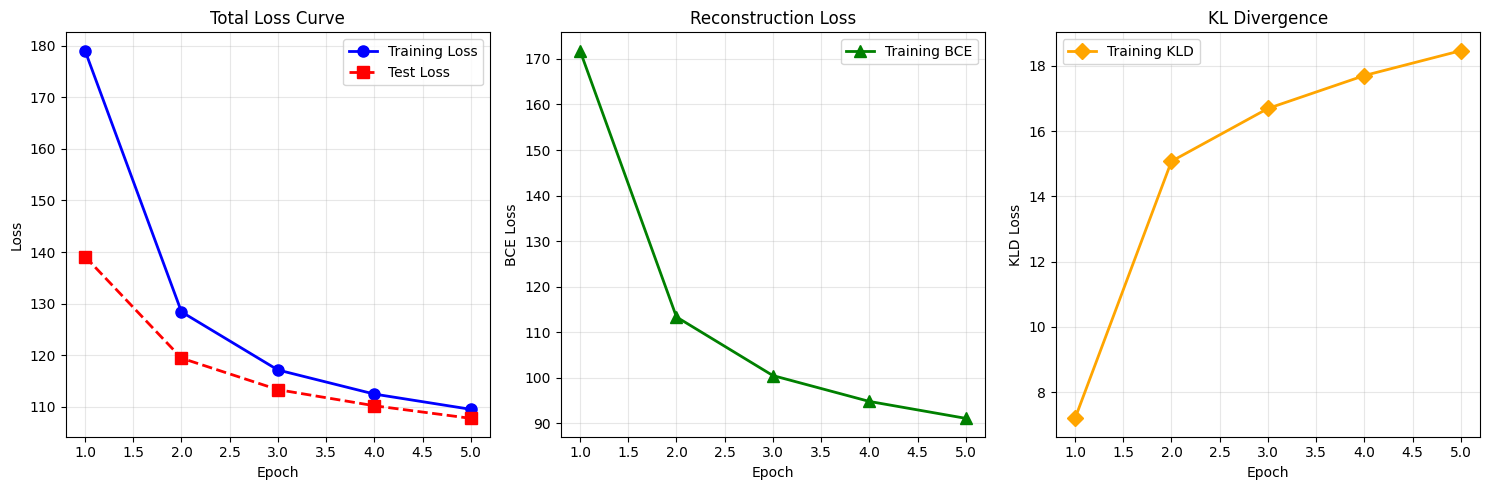


最終重建結果:


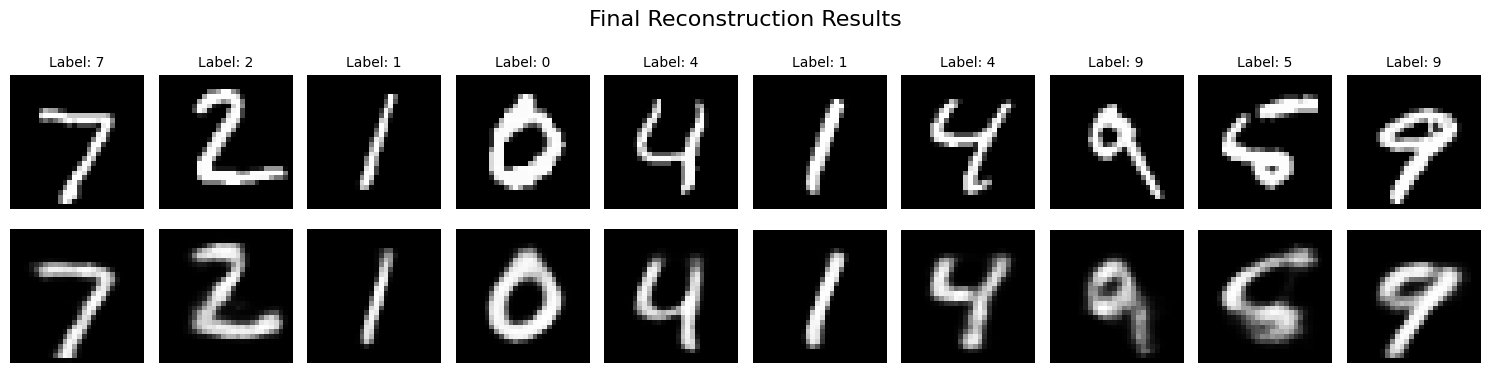


潛在空間可視化:


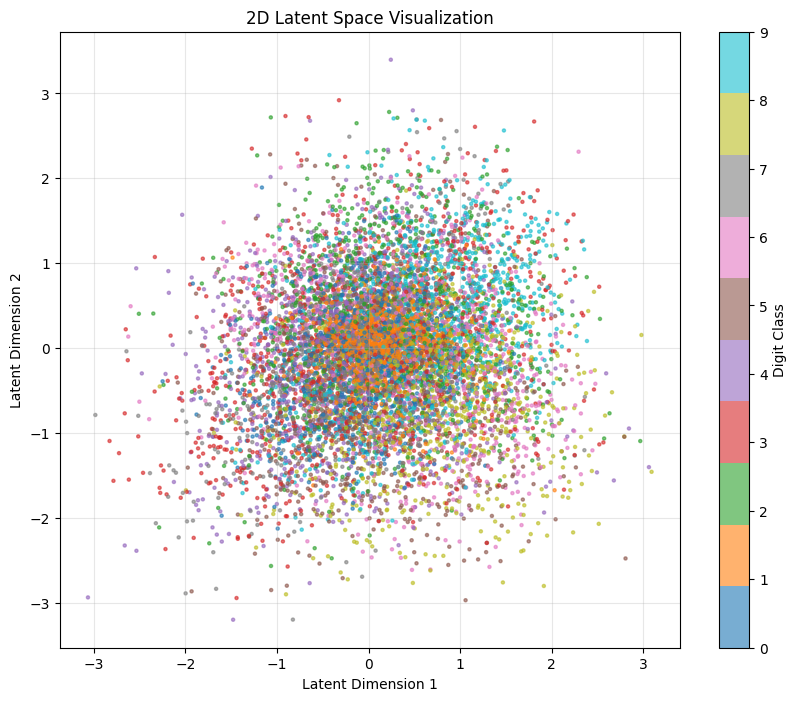

模型和訓練結果已保存為 'vae_mnist_final.pth'

生成新樣本:


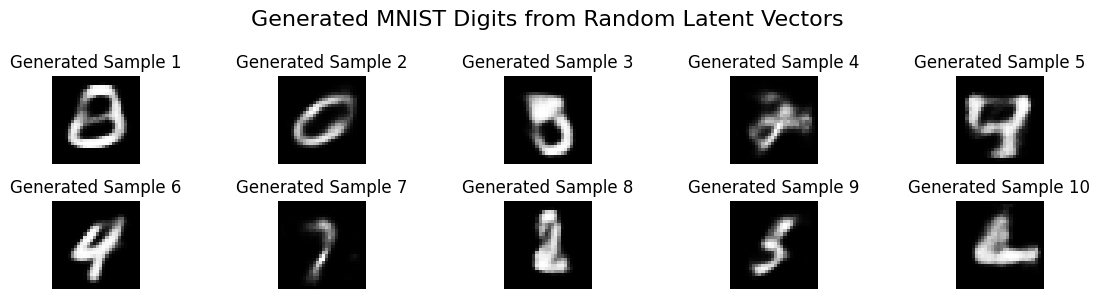


作業完成！所有結果已保存。
生成的檔案:
- reconstruction_epoch_1.png 到 reconstruction_epoch_5.png
- reconstruction_final.png
- training_curves.png
- latent_space.png
- generated_samples.png
- vae_mnist_final.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip
import struct
from tqdm import tqdm
import requests
from torchvision import transforms

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

def download_mnist():
    base_url = "https://github.com/fqnt/mnist/raw/main/"
    files = [
        "train-images-idx3-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz"
    ]

    os.makedirs('./data/mnist', exist_ok=True)

    for file in files:
        file_path = f'./data/mnist/{file}'
        if not os.path.exists(file_path):
            print(f"下載 {file}...")
            try:
                url = base_url + file
                response = requests.get(url, timeout=30)
                response.raise_for_status()
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                print(f"已下載: {file}")
            except Exception as e:
                print(f"下載 {file} 失敗: {e}")
                if not os.path.exists(file_path):
                    print("請手動下載檔案並放置在 ./data/mnist/ 目錄下")
        else:
            print(f"檔案已存在: {file}")

def read_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

class CustomMNIST(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = read_mnist_images(images_path)
        self.labels = read_mnist_labels(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

print("下載 MNIST 資料集...")
download_mnist()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = CustomMNIST(
    './data/mnist/train-images-idx3-ubyte.gz',
    './data/mnist/train-labels-idx1-ubyte.gz',
    transform=transform
)

test_dataset = CustomMNIST(
    './data/mnist/t10k-images-idx3-ubyte.gz',
    './data/mnist/t10k-labels-idx1-ubyte.gz',
    transform=transform
)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"訓練數據: {len(train_dataset)} 個樣本")
print(f"測試數據: {len(test_dataset)} 個樣本")

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.decoder_fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.encoder_fc1(x))
        h = F.relu(self.encoder_fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.decoder_fc1(z))
        h = F.relu(self.decoder_fc2(h))
        return torch.sigmoid(self.decoder_fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

input_dim = 784
hidden_dim = 400
latent_dim = 20

model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("模型結構:")
print(model)
print(f"可訓練參數數量: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

def train_epoch(epoch):
    model.train()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, _) in enumerate(progress_bar):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

        if batch_idx % 50 == 0:
            progress_bar.set_postfix({
                'Loss': f'{loss.item()/len(data):.2f}',
                'BCE': f'{bce.item()/len(data):.2f}',
                'KLD': f'{kld.item()/len(data):.2f}'
            })

    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)

    return avg_loss, avg_bce, avg_kld

def test_epoch():
    model.eval()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, bce, kld = loss_function(recon_batch, data, mu, logvar)
            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()

    avg_loss = total_loss / len(test_loader.dataset)
    avg_bce = total_bce / len(test_loader.dataset)
    avg_kld = total_kld / len(test_loader.dataset)

    return avg_loss, avg_bce, avg_kld

def visualize_reconstruction(epoch=None):
    model.eval()
    with torch.no_grad():
        data, labels = next(iter(test_loader))
        data = data.to(device)
        recon_batch, _, _ = model(data)

        data = data.cpu().numpy()
        recon_batch = recon_batch.cpu().numpy()
        labels = labels.cpu().numpy()

        fig, axes = plt.subplots(2, 10, figsize=(15, 4))

        for i in range(10):
            axes[0, i].imshow(data[i].reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Label: {labels[i]}', fontsize=10)

            axes[1, i].imshow(recon_batch[i].reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')

        axes[0, 0].set_ylabel('Original', fontsize=12)
        axes[1, 0].set_ylabel('Reconstructed', fontsize=12)

        if epoch is not None:
            plt.suptitle(f'Epoch {epoch} - MNIST Reconstruction Results', fontsize=16)
        else:
            plt.suptitle('Final Reconstruction Results', fontsize=16)

        plt.tight_layout()
        plt.savefig(f'reconstruction_epoch_{epoch if epoch else "final"}.png', dpi=300, bbox_inches='tight')
        plt.show()

epochs = 5
train_losses = []
test_losses = []
train_bces = []
train_klds = []

print("開始訓練 VAE 模型...")
print("=" * 60)

for epoch in range(1, epochs + 1):
    train_loss, train_bce, train_kld = train_epoch(epoch)
    train_losses.append(train_loss)
    train_bces.append(train_bce)
    train_klds.append(train_kld)

    test_loss, test_bce, test_kld = test_epoch()
    test_losses.append(test_loss)

    print(f"\nEpoch {epoch} 結果:")
    print(f"訓練損失: {train_loss:.4f} (BCE: {train_bce:.4f}, KLD: {train_kld:.4f})")
    print(f"測試損失: {test_loss:.4f}")
    print("-" * 40)

    visualize_reconstruction(epoch)

print("\n" + "=" * 60)
print("訓練完成!")
print("=" * 60)

for epoch, (t_loss, t_bce, t_kld, te_loss) in enumerate(zip(train_losses, train_bces, train_klds, test_losses), 1):
    print(f"Epoch {epoch}: 訓練損失: {t_loss:.4f} (BCE: {t_bce:.4f}, KLD: {t_kld:.4f}), 測試損失: {te_loss:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=8)
plt.plot(range(1, epochs + 1), test_losses, 'r--s', label='Test Loss', linewidth=2, markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), train_bces, 'g-^', label='Training BCE', linewidth=2, markersize=8)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(range(1, epochs + 1), train_klds, color='orange', marker='D', linestyle='-',
         label='Training KLD', linewidth=2, markersize=8)
plt.xlabel('Epoch')
plt.ylabel('KLD Loss')
plt.title('KL Divergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n最終重建結果:")
visualize_reconstruction()

def visualize_latent_space():
    model.eval()
    latent_vectors = []
    labels_list = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_vectors.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())

    latent_vectors = np.concatenate(latent_vectors)
    labels_list = np.concatenate(labels_list)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1],
                         c=labels_list, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space Visualization')
    plt.grid(True, alpha=0.3)
    plt.savefig('latent_space.png', dpi=300, bbox_inches='tight')
    plt.show()

if latent_dim >= 2:
    print("\n潛在空間可視化:")
    visualize_latent_space()

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'epoch': epochs
}, 'vae_mnist_final.pth')

print("模型和訓練結果已保存為 'vae_mnist_final.pth'")

def generate_new_samples(num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_images = model.decode(z)
        generated_images = generated_images.cpu().numpy()

        plt.figure(figsize=(12, 3))
        for i in range(num_samples):
            plt.subplot(2, 5, i + 1)
            plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
            plt.title(f'Generated Sample {i+1}')

        plt.suptitle('Generated MNIST Digits from Random Latent Vectors', fontsize=16)
        plt.tight_layout()
        plt.savefig('generated_samples.png', dpi=300, bbox_inches='tight')
        plt.show()

print("\n生成新樣本:")
generate_new_samples()

print("\n作業完成！所有結果已保存。")
print("生成的檔案:")
print("- reconstruction_epoch_1.png 到 reconstruction_epoch_5.png")
print("- reconstruction_final.png")
print("- training_curves.png")
print("- latent_space.png")
print("- generated_samples.png")
print("- vae_mnist_final.pth")